In [3]:
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import numpy as np
import tensorflow as tf
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model.coxph import BreslowEstimator
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
from sklearn.model_selection import train_test_split
from utility.training import get_data_loader, scale_data, make_time_event_split
from tools.model_builder import make_mcd_model, make_vi_model
from utility.config import load_config
from utility.loss import CoxPHLoss
import paths as pt

RUNS = 100

# Load config
config = load_config(pt.MLP_CONFIGS_DIR, f"SEER.yaml")
optimizer = tf.keras.optimizers.deserialize(config['optimizer'])
custom_objects = {"CoxPHLoss": CoxPHLoss()}
with tf.keras.utils.custom_object_scope(custom_objects):
    loss_fn = tf.keras.losses.deserialize(config['loss_fn'])
activation_fn = config['activiation_fn']
layers = config['network_layers']
dropout_rate = config['dropout_rate']
l2_reg = config['l2_reg']
batch_size = config['batch_size']

# Load data
dl = get_data_loader("SEER").load_data()
X, y = dl.get_data()
num_features, cat_features = dl.get_features()

# Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

# Scale data
X_train, X_test = scale_data(X_train, X_test, cat_features, num_features)
X_train = np.array(X_train)
X_test = np.array(X_test)

# Make time/event split
t_train, e_train = make_time_event_split(y_train)
t_test, e_test = make_time_event_split(y_test)

# Create model instance
model = make_vi_model(n_train_samples=X_train.shape[0],
                      input_shape=X_train.shape[1:], output_dim=2,
                      layers=layers, activation_fn=activation_fn,
                      dropout_rate=dropout_rate, regularization_pen=l2_reg)

# Restore the weights
curr_dir = os.getcwd()
root_dir = Path(curr_dir).absolute().parent
model.load_weights(f'{root_dir}/models/seer_vi')

optimizer = tf.keras.optimizers.Adam()
loss_fn = CoxPHLoss()

model.compile(loss=loss_fn, optimizer=optimizer)

`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.


In [4]:
# Make predictions
x_pred = X_test[:3]
for rep in range(5): #Predictions for 5 runs
    print(model.predict(x_pred, verbose=0)[0:3].T)

[[ 0.29089397  0.34443322 -0.62660575]]
[[ 1.8814006  -0.02888358  0.38638958]]
[[-0.79997253 -2.197862    0.08708039]]
[[0.9607682  0.19439496 0.6198016 ]]
[[-0.3070018  0.6632284  1.6023059]]


In [5]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_flipout_2 (DenseFlipo  (None, 16)               928       
 ut)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_flipout_3 (DenseFlipo  (None, 2)                68        
 ut)                                                             
                                                           

In [6]:
# Sample from the parameters for the post predictive
#from keras.models import Model
#layer_name = 'dense_flipout_23'
#model_params = Model(inputs=model.input,
#                     outputs=model.get_layer(layer_name).output)
#for rep in range(5): #Predictions for 5 runs
#    print(model_params.predict(x_pred, verbose=0)[0:3].T)

In [7]:
x_pred = X_test[:3]
vi_cpd = np.zeros((RUNS,len(x_pred)))
for i in range(0,RUNS):
    vi_cpd[i,:] = np.reshape(model.predict(x_pred, verbose=0), len(x_pred))

In [8]:
# Train the Brewslow estimator
train_predictions = model.predict(X_train, verbose=0).reshape(-1)
breslow = BreslowEstimator().fit(train_predictions, e_train, t_train)

# Make model predictions
x_sample = X_test
model_vi = np.zeros((RUNS, len(x_sample)))
for i in range(0, RUNS):
    model_vi[i,:] = np.reshape(model.predict(x_sample, verbose=0), len(x_sample))
    
# Predict the surv func using Breslow to estimate variance
event_times = breslow.get_survival_function(model_vi[0])[0].x
breslow_surv_times = np.zeros((len(x_sample), RUNS, len(event_times)))
for i in range(0, RUNS):
    surv_fns = breslow.get_survival_function(model_vi[i,:])
    for j, surv_fn in enumerate(surv_fns):
        breslow_surv_times[j,i,:] = surv_fn.y

<Figure size 512x384 with 0 Axes>

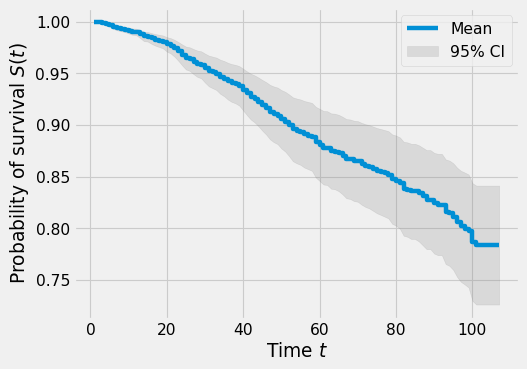

In [9]:
n_samples = breslow_surv_times.shape[1]

plt.figure(dpi=80)

obs_1_surv_times = breslow_surv_times[0,:,:]
ci_surv = 1.96 * np.std(obs_1_surv_times, axis=0) / np.sqrt(n_samples) # 95% CI
mean_surv_times = np.mean(obs_1_surv_times, axis=0)

# Plot surv funcs with mean and CI
plt.figure(dpi=80)
plt.step(event_times, mean_surv_times, where="post", label="Mean")
plt.fill_between(event_times, mean_surv_times-ci_surv, mean_surv_times+ci_surv,
                 color='gray', alpha=0.2, label="95% CI")
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$")
plt.legend()
plt.grid(True)
plt.show()